In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna


we are going to load and inspect the dataset, 
    displaying key information

    Parameters:
        -file_path(str):Path to dataset file
        -dataset_name(str): Name of the dataset to display

In [2]:
#getting the dataset
def load_data(file_path:str ,dataset_name='DataSet'):
    try:
        df=pd.read_csv(file_path,index_col='id')
        print(f"\n---{dataset_name} Inspection ---")
        
        #Display the rows
        print(f'\n{dataset_name} - First 5 Rows ===')
        print(df.head(5))
        
        #Display the shape of the data
        print(f'\n{dataset_name} Shape : {df.shape}')
        
        #display the information about the dataset
        print(f'\n {dataset_name} Info: ')
        print(df.info())
        
        #displaying the basic statistics of the dataset
        print(f'\n {dataset_name} Description:')
        print(df.describe())
        
        #checking the missing values present in the dataset
        print(f"\n{dataset_name}  Missing Values: ")
        print(df.isnull().sum())
        
        return df
    except FileNotFoundError:
        print(f"Error: file {file_path} not found !.Please recheck the file path...")
        return None
    except Exception as e:
        print(f"Error Loading '{dataset_name}': {str(e)}")
        return None

In [3]:
#Loading and Inspecting the dataset

train_path='/kaggle/input/prediction-interval-competition-ii-house-price/dataset.csv'
test_path='/kaggle/input/prediction-interval-competition-ii-house-price/test.csv'

train_df = load_data(train_path ,dataset_name='Training Data')

test_df=load_data(test_path,dataset_name='Test Data')



---Training Data Inspection ---

Training Data - First 5 Rows ===
     sale_date  sale_price  sale_nbr sale_warning join_status  join_year  \
id                                                                         
0   2014-11-15      236000       2.0                    nochg       2025   
1   1999-01-15      313300       NaN          26        nochg       2025   
2   2006-08-15      341000       1.0                    nochg       2025   
3   1999-12-15      267000       1.0                    nochg       2025   
4   2018-07-15     1650000       2.0                   miss99       2025   

    latitude  longitude  area         city  ... view_olympics view_cascades  \
id                                          ...                               
0    47.2917  -122.3658    53  FEDERAL WAY  ...             0             0   
1    47.6531  -122.1996    74     KIRKLAND  ...             0             0   
2    47.4733  -122.1901    30       RENTON  ...             0             0   
3    

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


         sale_price       sale_nbr      join_year       latitude  \
count  2.000000e+05  157818.000000  200000.000000  200000.000000   
mean   5.841495e+05       2.162599    2023.403600      47.549248   
std    4.170595e+05       1.113090       6.241643       0.142710   
min    5.029300e+04       1.000000    1999.000000      47.155200   
25%    3.050000e+05       1.000000    2025.000000      47.446500   
50%    4.599500e+05       2.000000    2025.000000      47.562800   
75%    7.249500e+05       3.000000    2025.000000      47.673500   
max    2.999950e+06      11.000000    2025.000000      47.777800   

           longitude           area    present_use      land_val  \
count  200000.000000  200000.000000  200000.000000  2.000000e+05   
mean     -122.210416      48.644215       4.108860  4.601691e+05   
std         0.140339      27.132002       7.199323  3.510444e+05   
min      -122.527700       1.000000       2.000000  0.000000e+00   
25%      -122.323800      26.000000       2.000

EDA(Exploratory Data Analysis)

This step will help us understand the distribution of sale_price, identify key features, handle missing values, and explore relationships. Given in our dataset’s size (200,000 rows) and features (numerical like area, year_built; categorical like city, zoning), we’ll focus on:

Target Distribution: Check if sale_price is skewed (common in house price data).
Missing Values: Address missing values in sale_nbr (21% missing), subdivision (8.8% missing), and submarket (0.9% missing).
Feature Correlations: Identify numerical features correlated with sale_price (e.g., area, beds).
Categorical Features: Explore unique values in city, zoning, subdivision to guide encoding.

In [4]:
def inspect_dataset(train_df:pd.DataFrame,test_df:pd.DataFrame,target_column='sale_price'):
    '''
        perform EDA on the house price dataset

        Parameters: 
            train_df(pd.DataFrame): Training dataset with features and target
            test_df(pd.DataFrame): Test Dataset about target.
            target_column(str):Target Column Name, default 'Sale_price'.
            
    '''

    #Target Distribution
    plt.figure(figsize=(10,6))
    sns.histplot(train_df[target_column],kde=True,bins=50)
    plt.title('Distribution of Sale Price')
    plt.xlabel('Sale Price')
    plt.ylabel('Count')
    plt.show()

    #printing the summary statistics for target column [sale price]
    print(f'\nSale Price Summary Statisrtics: ')
    print(train_df[target_column].describe())

    #claculating the skewness to check if sale_price is skewed
    skewness=train_df[target_column].skew()
    print(f"\nSale Price Skewness: {skewness: .4f} (Positive skew > 0,Consider LOG TRANSFORMATION if high")

    #Missing Values
    try:
        print("\nMissing Values in Train (%):")
        missing_train = train_df.isnull().sum()[train_df.isnull().sum() > 0] / len(train_df) * 100
        if missing_train.empty:
            print("No missing values in train dataset.")
        else:
            print(missing_train)
    except:
        print("Error computing missing values in train dataset.")
    
    try:
        print("\nMissing Values in Test (%):")
        missing_test = test_df.isnull().sum()[test_df.isnull().sum() > 0] / len(test_df) * 100
        if missing_test.empty:
            print("No missing values in test dataset.")
        else:
            print(missing_test)
    except:
        print("Error computing missing values in test dataset.")

    #Correlation with numerical features
    numerical_cols=train_df.select_dtypes(include=['int64','float64']).columns
    cor_matrix=train_df[numerical_cols].corr()

    #Correlation with Numerical Features
    plt.figure(figsize=(12,8))
    sns.heatmap(cor_matrix,cmap='coolwarm',annot=False)
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()


    #let us print top 5 related features with sale_price
    print(f"\n Top 5 Features realated with Sale Price:")
    top_corr=cor_matrix[target_column].sort_values(ascending=False).head(5)
    print(top_corr)

    #CATEGORICAL FEATURE ANALYSIS
    categorical_cols=train_df.select_dtypes(include=['object','category']).columns
    print("\nCategoroical Features - Unique Values:")
    for col in categorical_cols:
        print(f"{col}: {train_df[col].nunique()} unique values")
        print(train_df[col].value_counts().head())


    #key distribution
    key_features=['area','year_built','beds','bath_full']
    for feature in key_features:
        plt.figure(figsize=(10,8))
        sns.scatterplot(x=train_df[feature],y=train_df[target_column])
        plt.title(f"Sale Price vs {feature}")
        plt.xlabel(feature)
        plt.ylabel('Sale Price')
        plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


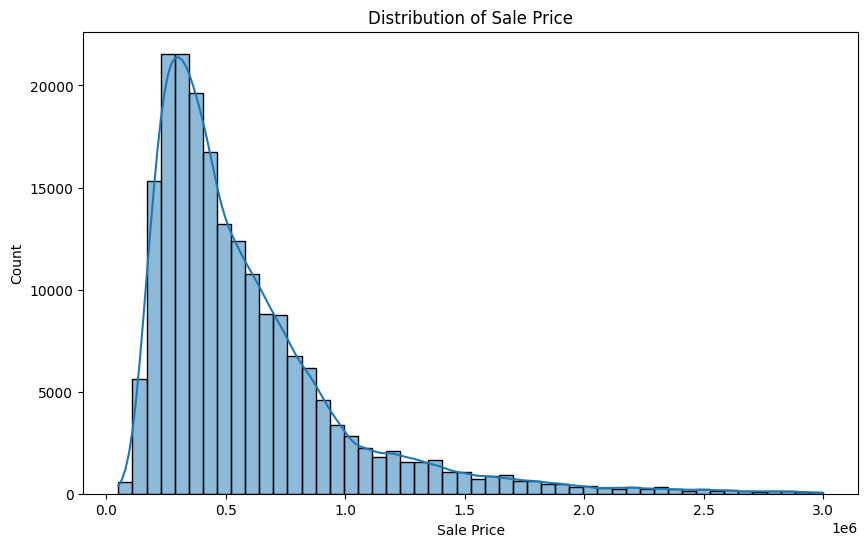


Sale Price Summary Statisrtics: 
count    2.000000e+05
mean     5.841495e+05
std      4.170595e+05
min      5.029300e+04
25%      3.050000e+05
50%      4.599500e+05
75%      7.249500e+05
max      2.999950e+06
Name: sale_price, dtype: float64

Sale Price Skewness:  2.0924 (Positive skew > 0,Consider LOG TRANSFORMATION if high

Missing Values in Train (%):
sale_nbr       21.0910
subdivision     8.7750
submarket       0.8585
dtype: float64

Missing Values in Test (%):
sale_nbr       21.206
subdivision     8.775
submarket       0.859
dtype: float64


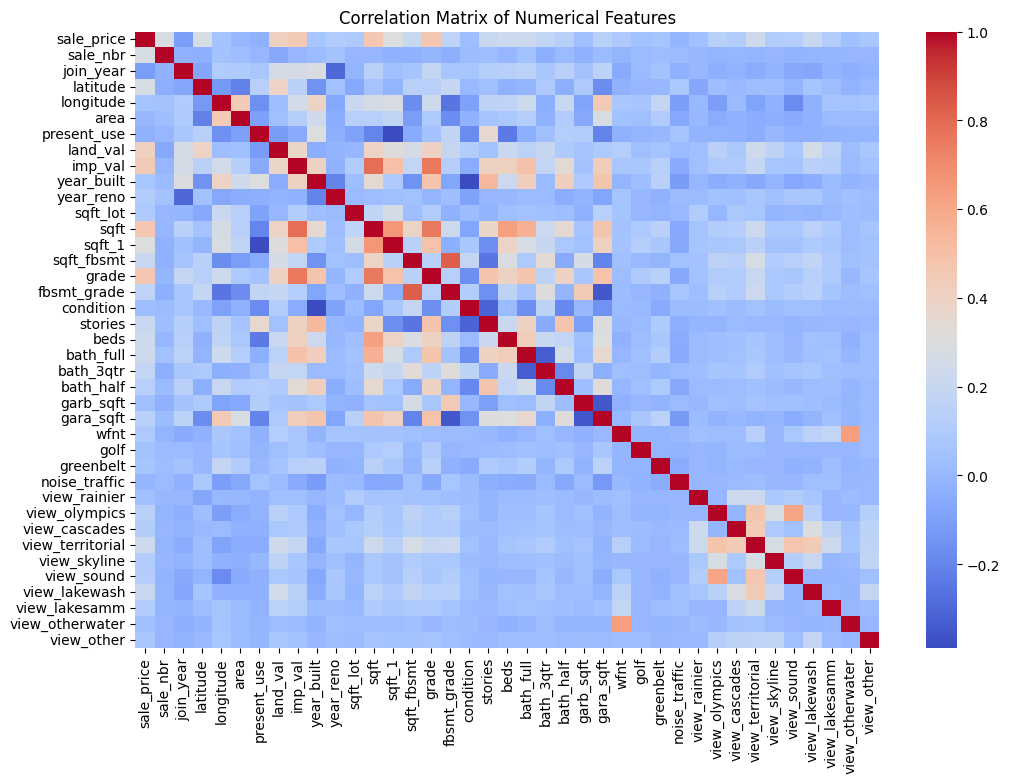


 Top 5 Features realated with Sale Price:
sale_price    1.000000
sqft          0.466253
grade         0.464287
imp_val       0.455197
land_val      0.412339
Name: sale_price, dtype: float64

Categoroical Features - Unique Values:
sale_date: 313 unique values
sale_date
2004-06-15    1221
2006-06-15    1159
2005-06-15    1146
2021-06-15    1090
2017-06-15    1086
Name: count, dtype: int64
sale_warning
       180689
26       6831
15       3723
40       2235
41       1999
Name: count, dtype: int64
join_status: 8 unique values
join_status
nochg               126281
new                  53085
reno - before         5864
rebuilt - before      3706
rebuilt - after       3095
Name: count, dtype: int64
city: 41 unique values
city
SEATTLE        59001
KING COUNTY    27127
BELLEVUE       10691
SAMMAMISH       9563
KENT            9429
Name: count, dtype: int64
zoning: 500 unique values
zoning
NR3    28800
R6     18728
R4     11031
RA5     8397
NR2     7165
Name: count, dtype: int64
subdivision: 10

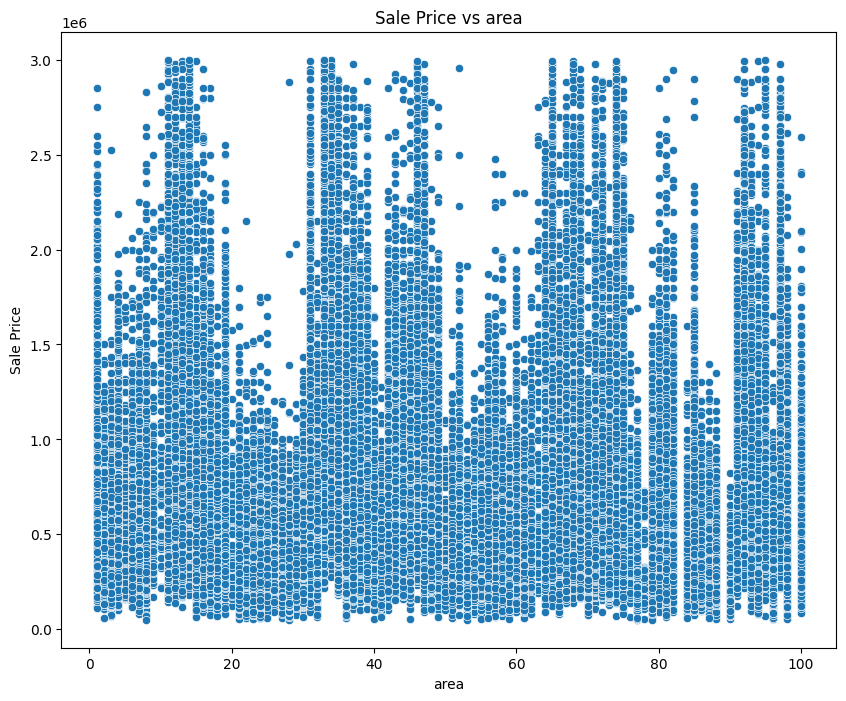

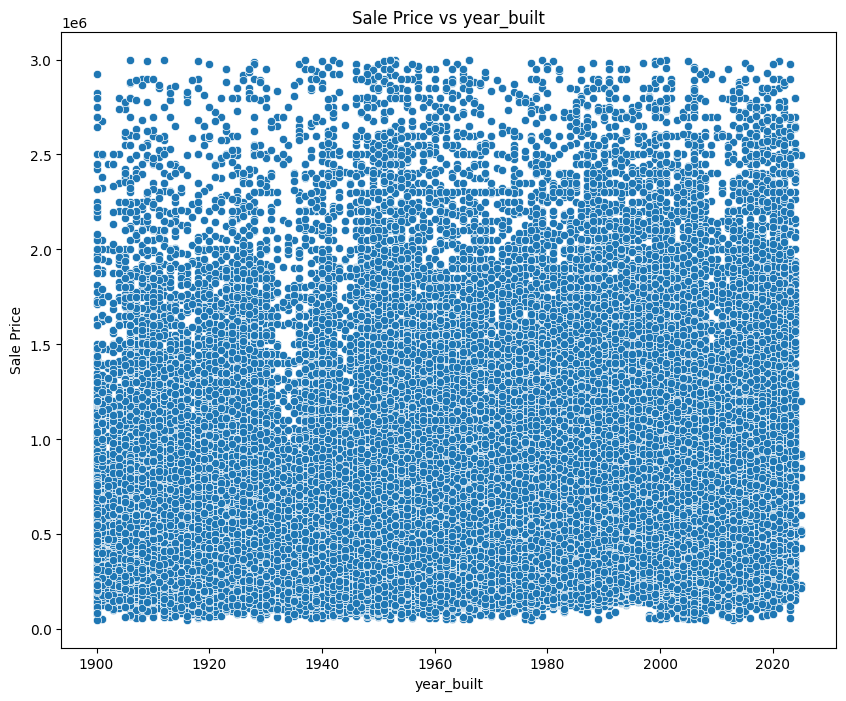

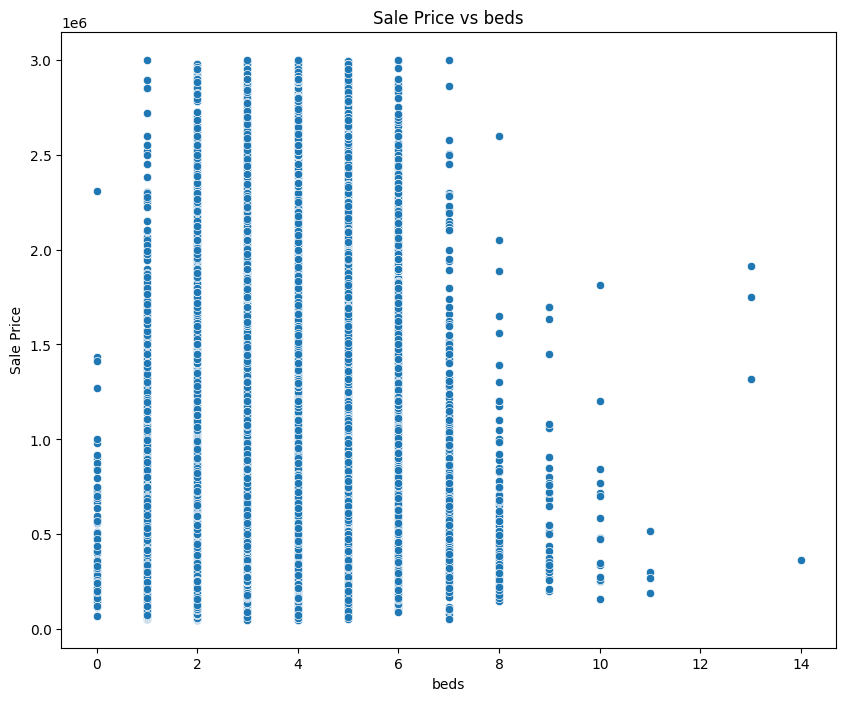

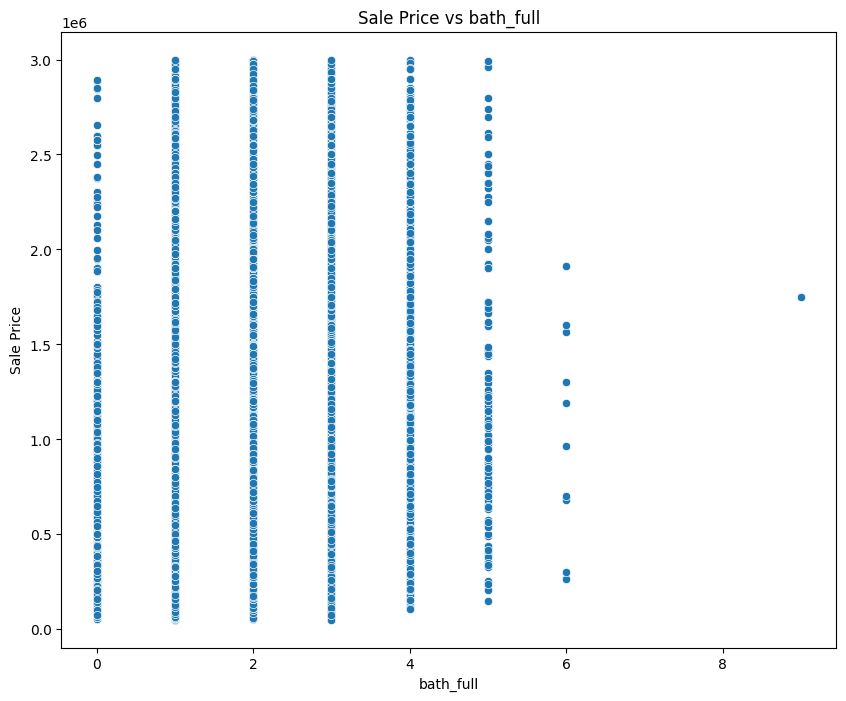

In [5]:
inspect_dataset(train_df, test_df, target_column='sale_price')

DATA PREPROCESSING


In [6]:
def preprocess_data(train_df:pd.DataFrame , test_df:pd.DataFrame , target_column='sale+price'):
    '''
        we are going to :
            1.preprocess train and test dataset
            2.handle the missing values
            3.encodeing categoricals and
            4.scaling numericals

        Parameters:
            train_df(pd.DataFrame):Training Dataset(200,000 roes , 45 features , sale_price).
            test_df(pd.DataFrame):Test Dataset (similar features , no sale price)
            target_column(str):Target column, default 'sale_price'(int 64),
            
    '''

    #printing column names for debugging
    print(f"Train Data Column: {train_df.columns.tolist()}")
    print(f"Test Data Column: {test_df.columns.tolist()}")

    #validating the target column
    if target_column not in train_df.columns:
        raise ValueError(f"Target Column '{target_column}' not found in training data😱.\nAvailaible olumns: {train_df.columns.tolist()}")


    #Detecting numerical and categorical columns
    numerical_cols=train_df.select_dtypes(include=['int64','float64']).columns.tolist()
    if target_column in numerical_cols:
        numerical_cols.remove(target_column)
    categorical_cols=train_df.select_dtypes(include=['object','category']).columns


    #Handling missing values
    for col in numerical_cols:
        try:
            median_value=train_df[col].median()
            train_df[col].fillna(median_value,inplace=True)
            test_df[df].fillna(median_value,inplace=True)
        except:
            print(f"No missing values in numerical columns: {col}")

    for col in categorical_cols:
        try:
            if col in ['subdivision']:
                train_df[col].fillna('None',inplace=True)
                test_df[col].fillna('None',inplace=True)
            else:
                mode_value=train_df[col].mode()[0]
                train_df[col].fillna(mode_value,inplace=True)
                test_df[col].fillna(mode_value,inplace=True)
        except:
            print(f"No missing values in categorical columns: {col}")

    x_train=train_df.drop(columns=[target_column])
    y_train=train_df[target_column]


    skewness=y_train.skew()
    if skewness>1:
        print(f"Log-Tranforming {target_column} due to high skewness ({skewness:.4f})")
        y_train=np.log1p(y_train)

    x_test=test_df.copy()


    #let's define preproseccing pipeline
    low_cardinality_cols=[col for col in categorical_cols if train_df[col].nunique()<10]
    high_cardinality_cols=[col for col in categorical_cols if train_df[col].nunique()>=10]

    preprocessor=ColumnTransformer(
        transformers=[
            #numerical pipeline:Scale Features
            ('num',Pipeline([
                ('scaler',StandardScaler())
            ]),numerical_cols),
            #for low cardinality categorical we will be using One-hot encode
            ('cat_low',Pipeline([
                ('encoder',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
                
            ]),low_cardinality_cols),

            #for high cardinality categorical we will use Target encode
            ('cat_high',Pipeline([
                ('encoder',TargetEncoder(smoothing=1.0))
            ]),high_cardinality_cols)
        ])
    #fit and transform
    x_train_preprocessed=preprocessor.fit_transform(x_train,y_train)
    x_test_preprocessed=preprocessor.transform(x_test)



    #getting feature names after preprocessign
    feature_names=(
        numerical_cols +
        list(preprocessor.named_transformers_['cat_low']['encoder'].get_feature_names_out(low_cardinality_cols)) +
        high_cardinality_cols
    )
    # Convert to DataFrame
    x_train_preprocessed = pd.DataFrame(x_train_preprocessed, columns=feature_names, index=x_train.index)
    x_test_preprocessed = pd.DataFrame(x_test_preprocessed, columns=feature_names, index=x_test.index)

    # Check for NaN values post-transformation
    if x_train_preprocessed.isna().any().any():
        print("Warning: NaN values found in x_train_preprocessed. Imputing with median.")
        x_train_preprocessed = x_train_preprocessed.fillna(x_train_preprocessed.median())
    if x_test_preprocessed.isna().any().any():
        print("Warning: NaN values found in x_test_preprocessed. Imputing with median.")
        x_test_preprocessed = x_test_preprocessed.fillna(x_train_preprocessed.median())

    print(f"\nPreprocessed Training Data Shape: {x_train_preprocessed.shape}")
    print(f"Preprocessed Test Data Shape: {x_test_preprocessed.shape}")
    print("\nPreprocessed Training Data Sample:")
    print(x_train_preprocessed.head())
    
    return x_train_preprocessed, x_test_preprocessed, y_train, preprocessor

In [7]:
x_train, x_test, y_train, preprocessor = preprocess_data(train_df, test_df, target_column='sale_price')

Train Data Column: ['sale_date', 'sale_price', 'sale_nbr', 'sale_warning', 'join_status', 'join_year', 'latitude', 'longitude', 'area', 'city', 'zoning', 'subdivision', 'present_use', 'land_val', 'imp_val', 'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt', 'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt', 'golf', 'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics', 'view_cascades', 'view_territorial', 'view_skyline', 'view_sound', 'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other', 'submarket']
Test Data Column: ['sale_date', 'sale_nbr', 'sale_warning', 'join_status', 'join_year', 'latitude', 'longitude', 'area', 'city', 'zoning', 'subdivision', 'present_use', 'land_val', 'imp_val', 'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt', 'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 'gar

/tmp/ipykernel_19/1423453565.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(median_value,inplace=True)
/tmp/ipykernel_19/1423453565.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

Log-Tranforming sale_price due to high skewness (2.0924)

Preprocessed Training Data Shape: (200000, 52)
Preprocessed Test Data Shape: (200000, 52)

Preprocessed Training Data Sample:
    sale_nbr  join_year  latitude  longitude      area  present_use  land_val  \
id                                                                              
0  -0.129472   0.255767 -1.804697  -1.107207  0.160541    -0.292926 -0.835136   
1  -0.129472   0.255767  0.727714   0.077070  0.934537    -0.292926  2.061940   
2  -1.138568   0.255767 -0.532185   0.144763 -0.687169    -0.292926 -0.655671   
3  -1.138568   0.255767 -0.527981  -0.848547  1.745389    -0.292926 -0.769617   
4  -0.129472   0.255767  1.417926   0.628592 -0.466027    -0.292926  0.443908   

     imp_val  year_built  year_reno  ...  join_status_rebuilt - after  \
id                                   ...                                
0  -0.325422    0.026690  -0.175252  ...                          0.0   
1   0.288626   -0.398920  -0.

**Model Training and Prediction Intervals**

we will be using 4 regression models 
    
    1.LinearRegression,
    2.RandomForestRegressor,
    3.RandomForestQuantileRegressor, 
    4.XGBRegressor

In [8]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna

def train_and_evaluate_models(x_train, y_train, x_test, k_folds=5):
    """
    Train regression models, evaluate with RMSE, and estimate prediction intervals.

    Parameters:
        x_train (pd.DataFrame): Preprocessed training features.
        y_train (pd.Series): Target (sale_price, possibly log-transformed).
        x_test (pd.DataFrame): Preprocessed test features.
        k_folds (int): Number of CV folds, default=5.
    """
    # Initialize models
    models = {
        'LinearRegression': LinearRegression(),
        'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBRegressor': XGBRegressor(random_state=42)
    }
    cv_scores = {}
    test_predictions = {}
    test_intervals = {}

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(x_train)):
            x_train_fold = x_train.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            x_val_fold = x_train.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]
    
            model.fit(x_train_fold, y_train_fold)
            y_pred = model.predict(x_val_fold)
            rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
            fold_scores.append(rmse)
            print(f"{model_name} - Fold {fold+1} RMSE: {rmse:.4f}")
    
        cv_scores[model_name] = np.mean(fold_scores)
        print(f"{model_name} - Mean CV RMSE: {cv_scores[model_name]:.4f} ± {np.std(fold_scores):.4f}")
        
        # Train on full data
        model.fit(x_train, y_train)
        test_pred = model.predict(x_test)
        test_predictions[model_name] = test_pred
        
        # Prediction intervals: Mean ± 2*std of CV residuals
        residuals = []
        for train_idx, val_idx in kf.split(x_train):
            model.fit(x_train.iloc[train_idx], y_train.iloc[train_idx])
            y_pred_val = model.predict(x_train.iloc[val_idx])
            residuals.extend(y_train.iloc[val_idx] - y_pred_val)
        std_residuals = np.std(residuals)
        test_intervals[model_name] = {
            'lower': test_pred - 2 * std_residuals,
            'upper': test_pred + 2 * std_residuals
        }
    
    # Tune XGBRegressor with Optuna
    def objective(trial):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        }
        xgb = XGBRegressor(**param, random_state=42)
        scores = []
        for train_idx, val_idx in kf.split(x_train):
            xgb.fit(x_train.iloc[train_idx], y_train.iloc[train_idx])
            y_pred = xgb.predict(x_train.iloc[val_idx])
            scores.append(np.sqrt(mean_squared_error(y_train.iloc[val_idx], y_pred)))
        return np.mean(scores)
    
    print("\nTuning XGBRegressor with Optuna...")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)
    print(f"Best XGBRegressor Parameters: {study.best_params}")
    
    tuned_xgb = XGBRegressor(**study.best_params, random_state=42)
    tuned_xgb.fit(x_train, y_train)
    test_predictions['Tuned_XGBRegressor'] = tuned_xgb.predict(x_test)
    residuals = []
    for train_idx, val_idx in kf.split(x_train):
        tuned_xgb.fit(x_train.iloc[train_idx], y_train.iloc[train_idx])
        y_pred_val = tuned_xgb.predict(x_train.iloc[val_idx])
        residuals.extend(y_train.iloc[val_idx] - y_pred_val)
    std_residuals = np.std(residuals)
    test_intervals['Tuned_XGBRegressor'] = {
        'lower': test_predictions['Tuned_XGBRegressor'] - 2 * std_residuals,
        'upper': test_predictions['Tuned_XGBRegressor'] + 2 * std_residuals
    }
    cv_scores['Tuned_XGBRegressor'] = study.best_value
    
    return models, cv_scores, test_predictions, test_intervals

In [9]:
models, cv_scores, test_predictions, test_intervals = train_and_evaluate_models(
    x_train, y_train, x_test, k_folds=5
)


Training LinearRegression...
LinearRegression - Fold 1 RMSE: 0.2034
LinearRegression - Fold 2 RMSE: 0.2025
LinearRegression - Fold 3 RMSE: 0.2027
LinearRegression - Fold 4 RMSE: 0.2022
LinearRegression - Fold 5 RMSE: 0.2025
LinearRegression - Mean CV RMSE: 0.2027 ± 0.0004

Training RandomForestRegressor...
RandomForestRegressor - Fold 1 RMSE: 0.1631
RandomForestRegressor - Fold 2 RMSE: 0.1638
RandomForestRegressor - Fold 3 RMSE: 0.1624
RandomForestRegressor - Fold 4 RMSE: 0.1612
RandomForestRegressor - Fold 5 RMSE: 0.1625
RandomForestRegressor - Mean CV RMSE: 0.1626 ± 0.0009

Training XGBRegressor...
XGBRegressor - Fold 1 RMSE: 0.1556
XGBRegressor - Fold 2 RMSE: 0.1572
XGBRegressor - Fold 3 RMSE: 0.1567
XGBRegressor - Fold 4 RMSE: 0.1558
XGBRegressor - Fold 5 RMSE: 0.1543
XGBRegressor - Mean CV RMSE: 0.1559 ± 0.0010


[I 2025-06-28 06:20:49,114] A new study created in memory with name: no-name-9afa4896-880d-455c-96e7-97632c96529d



Tuning XGBRegressor with Optuna...


[I 2025-06-28 06:20:57,577] Trial 0 finished with value: 0.15316229012905602 and parameters: {'n_estimators': 118, 'max_depth': 6, 'learning_rate': 0.1885697045335858}. Best is trial 0 with value: 0.15316229012905602.
[I 2025-06-28 06:21:05,149] Trial 1 finished with value: 0.29364419240952616 and parameters: {'n_estimators': 121, 'max_depth': 4, 'learning_rate': 0.012460033852327381}. Best is trial 0 with value: 0.15316229012905602.
[I 2025-06-28 06:21:16,703] Trial 2 finished with value: 0.2280173976894809 and parameters: {'n_estimators': 181, 'max_depth': 4, 'learning_rate': 0.014285689137190923}. Best is trial 0 with value: 0.15316229012905602.
[I 2025-06-28 06:21:26,019] Trial 3 finished with value: 0.17296157462743839 and parameters: {'n_estimators': 152, 'max_depth': 5, 'learning_rate': 0.03536316528867709}. Best is trial 0 with value: 0.15316229012905602.
[I 2025-06-28 06:21:38,227] Trial 4 finished with value: 0.15179717309741614 and parameters: {'n_estimators': 145, 'max_dept

Best XGBRegressor Parameters: {'n_estimators': 282, 'max_depth': 9, 'learning_rate': 0.07036734187316383}


In [10]:
def create_submission(test_df, test_predictions, test_intervals, log_transformed=False, model_name='Tuned_XGBRegressor'):
    """
    Create submission file with sale_price and 90% prediction intervals.

    Parameters:
        test_df (pd.DataFrame): Original test dataset (for index or id column).
        test_predictions (dict): Model predictions for x_test.
        test_intervals (dict): Prediction intervals (lower, upper) for x_test.
        log_transformed (bool): Whether y_train was log-transformed in Step 3.
        model_name (str): Model to use for submission (default: Tuned_XGBRegressor).
    """
    # Selecting the predictions and intervals for the chosen model
    if model_name not in test_predictions:
        raise ValueError(f"Model {model_name} not found in test_predictions. Available: {list(test_predictions.keys())}")
    
    predictions = test_predictions[model_name]
    intervals = test_intervals[model_name]
    
    # Reverse log-transformation if applied
    if log_transformed:
        print("Reversing log-transformation for predictions and intervals...")
        predictions = np.expm1(predictions)
        intervals['lower'] = np.expm1(intervals['lower'])
        intervals['upper'] = np.expm1(intervals['upper'])

    # Create submission DataFrame
    submission = pd.DataFrame({
        'id': test_df.index,  # Assumes test_df index is the ID; adjust if there's an 'id' column
        'sale_price': predictions,
        'lower': intervals['lower'],
        'upper': intervals['upper']
    })

    # Ensure non-negative predictions (house prices can't be negative)
    submission['sale_price'] = submission['sale_price'].clip(lower=0)
    submission['lower'] = submission['lower'].clip(lower=0)
    submission['upper'] = submission['upper'].clip(lower=0)

    # Save submission file
    submission.to_csv('submission.csv', index=False)
    print("Submission file created: submission.csv")
    print("Submission head:")
    print(submission.head())
    def evaluate_intervals(x_train, y_train, model, log_transformed):
        from sklearn.model_selection import train_test_split
        x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
        model.fit(x_tr, y_tr)
        val_pred = model.predict(x_val)
        residuals = y_val - val_pred
        std_residuals = np.std(residuals)
        val_intervals = {
            'lower': val_pred - 2 * std_residuals,
            'upper': val_pred + 2 * std_residuals
        }
        if log_transformed:
            val_pred = np.expm1(val_pred)
            val_intervals['lower'] = np.expm1(val_intervals['lower'])
            val_intervals['upper'] = np.expm1(val_intervals['upper'])
            y_val = np.expm1(y_val)
        # Coverage: % of true values within intervals
        coverage = np.mean((y_val >= val_intervals['lower']) & (y_val <= val_intervals['upper']))
        # Mean interval width
        width = np.mean(val_intervals['upper'] - val_intervals['lower'])
        # RMSE
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        print(f"\nValidation Metrics for {model_name}:")
        print(f"Coverage (90% target): {coverage:.4f}")
        print(f"Mean Interval Width: {width:.2f}")
        print(f"Validation RMSE: {rmse:.4f}")
        return coverage, width, rmse

    return submission

In [11]:
submission = create_submission(test_df, test_predictions, test_intervals, log_transformed=True, model_name='Tuned_XGBRegressor')

Reversing log-transformation for predictions and intervals...
Submission file created: submission.csv
Submission head:
       id    sale_price         lower         upper
0  200000  906840.43750  678900.43750  1.211311e+06
1  200001  700109.12500  524132.28125  9.351699e+05
2  200002  536599.12500  401721.46875  7.167617e+05
3  200003  362495.75000  271380.03125  4.842034e+05
4  200004  495611.28125  371036.18750  6.620122e+05
